In [258]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from scalable_gps import kernels
from scalable_gps import thompson_sampling

seed = 0
D = 1

kernel_name = "Matern32Kernel"
signal_scale = 1.0
length_scale = jnp.array([0.1])
noise_scale = 1e-3

kernel_init_fn = getattr(kernels, kernel_name)
kernel = kernel_init_fn({'signal_scale': signal_scale, 'length_scale': length_scale})

n_features = 1000
n_data_init = 10
n_friends = 50
n_homies = 15
n_samples = 10

feature_fn, objective_fn, ds_init = thompson_sampling.init(seed, D, kernel, n_features=n_features, n_data_init=n_data_init)
L_init = feature_fn(ds_init.x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
### ExactGP
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.data import Dataset

exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
alpha_map = exact_gp.compute_representer_weights(ds_init)

friends_key = jax.random.PRNGKey(42)
x_friends = thompson_sampling.find_friends(friends_key, ds_init, n_friends)
ds_friends = Dataset(x_friends, None, n_friends, D)
L = jnp.concatenate([L_init, feature_fn(x_friends)], axis=0)
print(L.shape)

samples_key = jax.random.PRNGKey(1337)
y_friends, alpha_samples, w_samples = exact_gp.compute_posterior_samples(samples_key, n_samples, ds_init, ds_friends, use_rff=True, L=L, zero_mean=False)
print(y_friends.shape, alpha_samples.shape, w_samples.shape)

acquisition_fn = thompson_sampling.get_acquisition_fn(ds_init, alpha_map, alpha_samples, w_samples, feature_fn, kernel.kernel_fn)

(60, 1000)
(10, 50) (10, 10) (10, 1000)


In [260]:
# find homies
x_homies = thompson_sampling.find_homies(x_friends, y_friends, n_homies)
# optimize homies
x_homies_optim, trace = thompson_sampling.optimise_homies(x_homies, acquisition_fn)
# find bestie
x_besties = thompson_sampling.find_besties(x_homies_optim, acquisition_fn)
# add bestie to ds

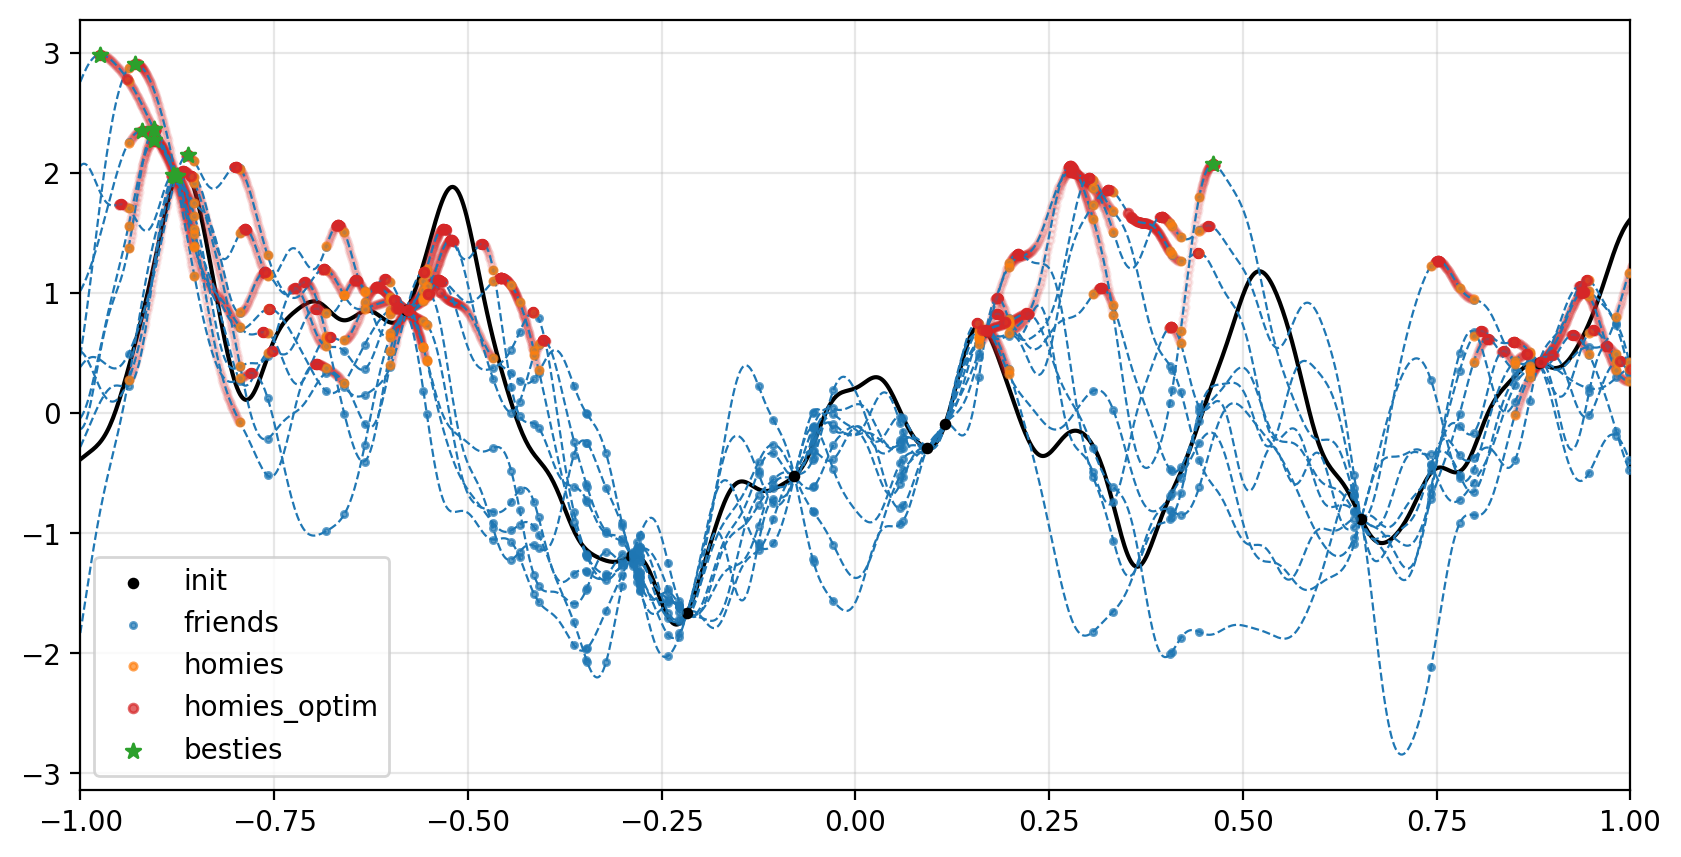

In [269]:
import matplotlib.pyplot as plt

ds = ds_friends

n_plot = 1000
x_plot = jnp.linspace(-1, 1, num=n_plot)[:, None]

fig = plt.figure(dpi=200, figsize=[10, 5])
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.plot(x_plot, objective_fn(x_plot), color='k')
ax.scatter(ds_init.x, ds_init.y, color='k', marker='o', s=10, zorder=3, label='init')
ax.scatter(x_friends.repeat(n_samples, axis=0), y_friends.T.ravel(), color='tab:blue', marker='o', s=5, zorder=3, alpha=0.7, label='friends')
ax.scatter(x_homies, acquisition_fn(x_homies)[0], color='tab:orange', marker='o', s=7, zorder=3, alpha=0.7, label='homies')
for (x, y) in trace:
    ax.scatter(x, y, color='tab:red', marker='o', s=7, zorder=2, alpha=0.1)
ax.scatter(x_homies_optim, acquisition_fn(x_homies_optim)[0], color='tab:red', marker='o', s=10, zorder=3, alpha=0.7, label='homies_optim')
ax.scatter(x_besties, acquisition_fn(x_besties)[0], color='tab:green', marker='*', s=30, zorder=4, label='besties')
ax.plot(x_plot, acquisition_fn(x_plot[None, :].repeat(n_samples, axis=0))[0].T, color='tab:blue', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3, zorder=0)
ax.legend()